# FinOL
## Tutorial 4: Training a Model
In Tutorial 4, we will continue building on the progress made in Tutorial 2 by utilizing the dataset ``SP500`` loaded using the techniques covered in the previous tutorial.  Now that we have successfully loaded the dataset, we will focus on training a model using these DataLoaders.

Throughout Tutorial 4, we will provide step-by-step instructions and code examples to guide you through the training process.  By the end of this tutorial, you will have a trained model that can make predictions on new data.

Make sure to refer back to Tutorial 2 if you need a refresher on loading the dataset. Once you have the DataLoaders, you are ready to proceed with training.

We first import the ``data_loader``, ``trainer``, and other necessary packages for Tutorial 3.

In [1]:
import re
import matplotlib
import matplotlib.pyplot as plt
from rich import print
from finol.data_layer.data_loader import *
from finol.optimization_layer.model_trainer import *
from finol.config import *

with open(ROOT_PATH + '/config.py', 'r') as file:
    content = file.read()

content = re.sub(r'(TUTORIAL_MODE\s*=\s*).*', r'\g<1>True', content)
content = re.sub(r'(TUTORIAL_NAME\s*=\s*").*?(")', r'\g<1>' + "TUTORIAL_4" + r'\g<2>', content)

with open(ROOT_PATH + '/config.py', 'w') as file:
    file.write(content)

UnicodeDecodeError: 'gbk' codec can't decode byte 0x80 in position 650: illegal multibyte sequence

As mentioned previously in Tutorial 2, we first load the dataset for our machine learning model using the ``load_dataset`` function.    This function takes care of loading the data from a file, parsing it, and preprocessing it to prepare it for training, validation, and testing.

Successfully loaded 9 Excel file(s):

{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x21e59297b20>,
 'val_loader': <torch.utils.data.dataloader.DataLoader at 0x21e59297a90>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x21e59297340>,
 'NUM_TRAIN_PERIODS': 4000,
 'NUM_VAL_PERIODS': 786,
 'NUM_TEST_PERIODS': 790,
 'NUM_ASSETS': 9,
 'NUM_FEATURES_AUGMENTED': 250,
 'NUM_FEATURES_ORIGINAL': 25,
 'WINDOW_SIZE': 10}

We next define a custom loss function called ``criterion`` for the following training process. In ``FinOL``, users have the flexibility to define their own custom loss functions.  This allows users to tailor the training process to their specific needs.  For example, users may want to define a custom loss function that includes risk measurement.

In [3]:
def criterion(preds, labels):
    dot_product = torch.sum(preds * labels, dim=1)
    # log_max_dot_product = torch.log(dot_product, min=1e-6)
    log_max_dot_product = torch.log(dot_product, min=1e-6)
    loss = -torch.mean(log_max_dot_product)

    return loss

**Training the Model**

Next, we will implement an LSTM model to perform OLPS task.  The model will be trained and evaluated using Pytorch lightweight deep learning library for efficient operations.

We first define the model architecture with the LSTM layer, specifying the input feature and output sizes based on the dataset characteristics obtained from the data loading stage.  The model is then moved to the designated device, in this case the GPU, for accelerating computations.

An Adam optimizer is chosen for training the network weights in a stochastic manner.  Several hyperparameters like learning rate, number of epochs etc. are loaded from the configuration file for reproducibility.  The training and validation losses are tracked across epochs to monitor convergence.

The core training loop iterates over mini-batches from the training dataloader, performs forward, backward and optimization steps at each turn.  Validation loss is also computed periodically to select the best performing model checkpoint for later deployment.

This covers the essential components involved in setting up and executing a deep learning workflow on financial data within the PyTorch framework as implemented in our tutorial.  We are now ready to kick off model training and analysis of results.


The following code shows the training process:

In [3]:
# # 单独放在一个单元格的最开始
# %matplotlib inline

In [4]:
from finol.model_layer.LSTM import *
from finol.config import ROOT_PATH
from finol.config import DATASET_NAME
from finol.config import DEVICE
from finol.config import NUM_EPOCHES
from finol.config import LEARNING_RATE


torch.manual_seed(42)
print(info_dict)
# print(f"{info_dict}")
NUM_ASSETS = info_dict['NUM_ASSETS']
NUM_TRAIN_PERIODS = info_dict['NUM_TRAIN_PERIODS']
NUM_VAL_PERIODS = info_dict['NUM_VAL_PERIODS']
NUM_TEST_PERIODS = info_dict['NUM_TEST_PERIODS']
NUM_FEATURES_AUGMENTED = info_dict['NUM_FEATURES_AUGMENTED']
NUM_FEATURES_ORIGINAL = info_dict['NUM_FEATURES_ORIGINAL']
WINDOW_SIZE = info_dict['WINDOW_SIZE']

model = LSTM(
    num_assets=NUM_ASSETS,
    num_features_augmented=NUM_FEATURES_AUGMENTED,
    num_features_original=NUM_FEATURES_ORIGINAL,
    window_size=WINDOW_SIZE
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_list = []
val_loss_list = []
y = []
best_val_loss = float('inf')

os.chdir(ROOT_PATH)
logdir = 'evaluation_layer/' + str(time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()))
os.mkdir(logdir)
copy2('config.py', logdir)

# Create a figure and axis object
for e in range(NUM_EPOCHES):
    train_loss = 0
    for i, data in enumerate(train_loader, 1):
        x_data, label = data
        out = model(x_data.float())
        loss = criterion(out, label.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(val_loader, 1):
            val_data, label = data
            out = model(val_data.float())
            loss = criterion(out, label.float())

            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

        # Model saving
        if val_loss < best_val_loss:
            # print('Saving the best model')
            best_val_loss = val_loss
            torch.save(model.state_dict(), logdir + '/best_model_'+DATASET_NAME+'.pt')

    y.append(np.array([train_loss, val_loss]))
    if (e + 1) % 10 == 0:
        print('Epoch: {}, Train Loss: {}, Val Loss: {}'.format(e + 1, train_loss, val_loss))
        plot_durations(np.array(y))

    plt.clf()

NameError: name 'info_dict' is not defined

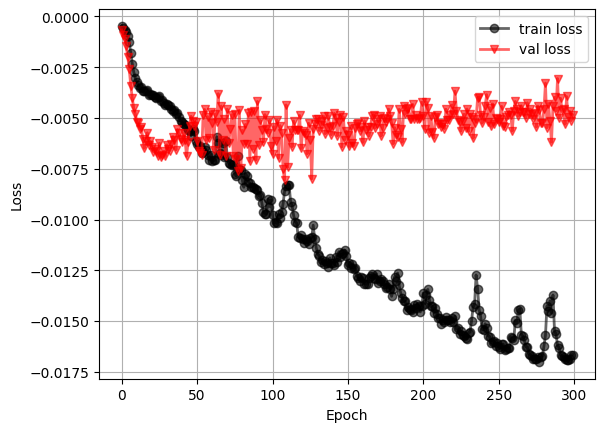

<Figure size 640x480 with 0 Axes>

In [6]:
from finol.model_layer.LSTM import *
from finol.config import ROOT_PATH
from finol.config import DATASET_NAME
from finol.config import DEVICE
from finol.config import NUM_EPOCHES
from finol.config import LEARNING_RATE


torch.manual_seed(42)
print(info_dict)
# print(f"{info_dict}")
NUM_ASSETS = info_dict['NUM_ASSETS']
NUM_TRAIN_PERIODS = info_dict['NUM_TRAIN_PERIODS']
NUM_VAL_PERIODS = info_dict['NUM_VAL_PERIODS']
NUM_TEST_PERIODS = info_dict['NUM_TEST_PERIODS']
NUM_FEATURES_AUGMENTED = info_dict['NUM_FEATURES_AUGMENTED']
NUM_FEATURES_ORIGINAL = info_dict['NUM_FEATURES_ORIGINAL']
WINDOW_SIZE = info_dict['WINDOW_SIZE']

model = LSTM(
    num_assets=NUM_ASSETS,
    num_features_augmented=NUM_FEATURES_AUGMENTED,
    num_features_original=NUM_FEATURES_ORIGINAL,
    window_size=WINDOW_SIZE
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_list = []
val_loss_list = []
y = []
best_val_loss = float('inf')

os.chdir(ROOT_PATH)
logdir = 'evaluation_layer/' + str(time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()))
os.mkdir(logdir)
copy2('config.py', logdir)

# Create a figure and axis object
for e in range(NUM_EPOCHES):
    train_loss = 0
    for i, data in enumerate(train_loader, 1):
        x_data, label = data
        out = model(x_data.float())
        loss = criterion(out, label.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(val_loader, 1):
            val_data, label = data
            out = model(val_data.float())
            loss = criterion(out, label.float())

            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

        # Model saving
        if val_loss < best_val_loss:
            # print('Saving the best model')
            best_val_loss = val_loss
            torch.save(model.state_dict(), logdir + '/best_model_'+DATASET_NAME+'.pt')

    y.append(np.array([train_loss, val_loss]))
    if (e + 1) % 10 == 0:
        print('Epoch: {}, Train Loss: {}, Val Loss: {}'.format(e + 1, train_loss, val_loss))
        plot_durations(np.array(y))

    plt.clf()

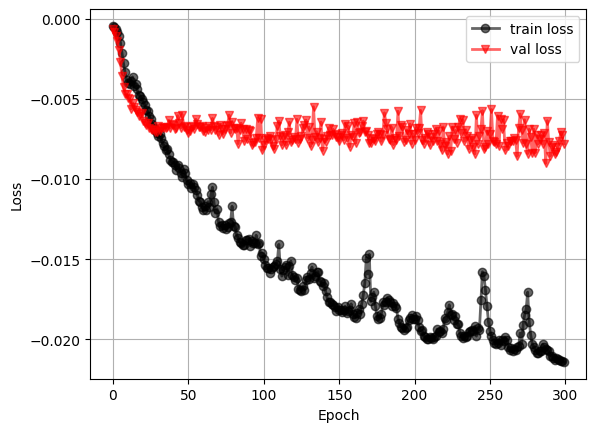

<Figure size 640x480 with 0 Axes>

In [5]:
from finol.model_layer.LSTM import *
from finol.config import ROOT_PATH
from finol.config import DATASET_NAME
from finol.config import DEVICE
from finol.config import NUM_EPOCHES
from finol.config import LEARNING_RATE


torch.manual_seed(42)
print(info_dict)
# print(f"{info_dict}")
NUM_ASSETS = info_dict['NUM_ASSETS']
NUM_TRAIN_PERIODS = info_dict['NUM_TRAIN_PERIODS']
NUM_VAL_PERIODS = info_dict['NUM_VAL_PERIODS']
NUM_TEST_PERIODS = info_dict['NUM_TEST_PERIODS']
NUM_FEATURES_AUGMENTED = info_dict['NUM_FEATURES_AUGMENTED']
NUM_FEATURES_ORIGINAL = info_dict['NUM_FEATURES_ORIGINAL']
WINDOW_SIZE = info_dict['WINDOW_SIZE']

model = LSTM(
    num_assets=NUM_ASSETS,
    num_features_augmented=NUM_FEATURES_AUGMENTED,
    num_features_original=NUM_FEATURES_ORIGINAL,
    window_size=WINDOW_SIZE
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_list = []
val_loss_list = []
y = []
best_val_loss = float('inf')

os.chdir(ROOT_PATH)
logdir = 'evaluation_layer/' + str(time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()))
os.mkdir(logdir)
copy2('config.py', logdir)

# Create a figure and axis object
for e in range(NUM_EPOCHES):
    train_loss = 0
    for i, data in enumerate(train_loader, 1):
        x_data, label = data
        out = model(x_data.float())
        loss = criterion(out, label.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(val_loader, 1):
            val_data, label = data
            out = model(val_data.float())
            loss = criterion(out, label.float())

            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

        # Model saving
        if val_loss < best_val_loss:
            # print('Saving the best model')
            best_val_loss = val_loss
            torch.save(model.state_dict(), logdir + '/best_model_'+DATASET_NAME+'.pt')

    y.append(np.array([train_loss, val_loss]))
    if (e + 1) % 10 == 0:
        print('Epoch: {}, Train Loss: {}, Val Loss: {}'.format(e + 1, train_loss, val_loss))
        plot_durations(np.array(y))

    plt.clf()

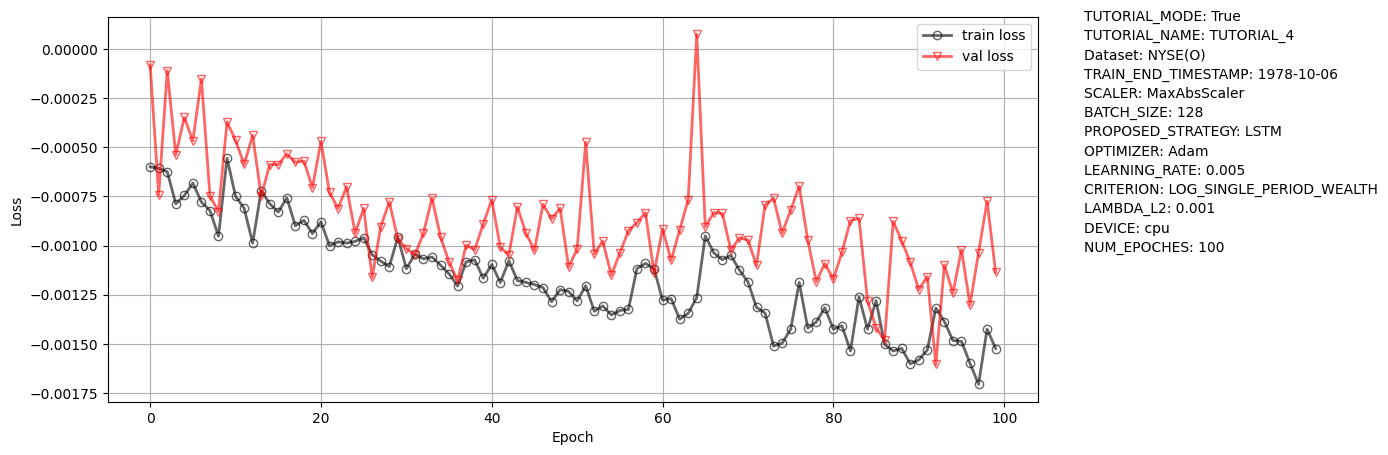

In [3]:
train_model_output = train_model(load_dataset_output)

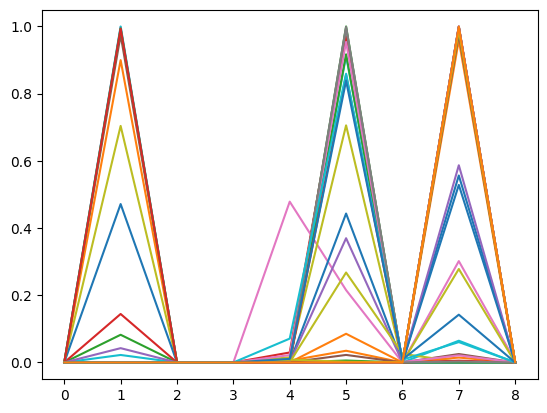

In [4]:
model = train_model_output["last_model"]
model.eval()
for i, data in enumerate(load_dataset_output["train_loader"], 1):
    x_data, label = data
    portfolio = model(x_data.float())

plt.figure()
plt.plot(portfolio.detach().numpy().T)
plt.show()

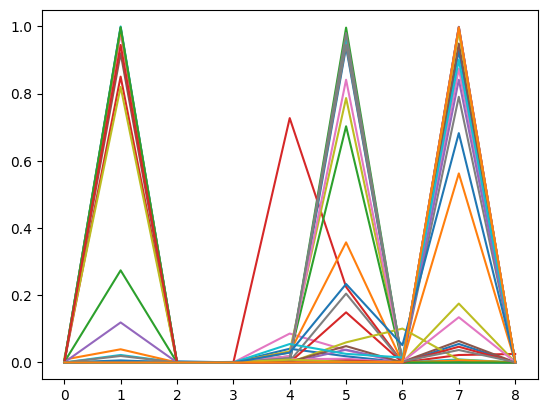

In [5]:
model = train_model_output["best_model"]
model.eval()
for i, data in enumerate(load_dataset_output["train_loader"], 1):
    x_data, label = data
    portfolio = model(x_data.float())

plt.figure()
plt.plot(portfolio.detach().numpy().T)
plt.show()